# Imbalanced Classification with the Fraudulent Credit Card Transactions Dataset 

* Fraud is a major problem for credit card companies, both because of the large volume of transactions that are completed each day and because many fraudulent transactions look a lot like normal transactions.

* Identifying fraudulent credit card transactions is a common type of imbalanced binary classification where the focus is on the positive class (is fraud) class.

* As such, metrics like precision and recall can be used to summarize model performance in terms of class labels and precision-recall curves can be used to summarize model performance across a range of probability thresholds when mapping predicted probabilities to class labels. (이진 분류 문제이므로 Precision, recall 과 같은 metric을 활용할 수 있음)

* This gives the operator of the model control over how predictions are made in terms of biasing toward false positive or false negative type errors made by the model.  
&nbsp;(Precision-recall curve는 false positive/negative 에 대한 정보를 주기 때문에 잘 활용하자)

* In this tutorial, you will discover how to develop and evaluate a model for the imbalanced credit card fraud dataset.

* After completing this tutorial, you will know:

    * How to load and explore the dataset and generate ideas for data preparation and model selection.
    * How to systematically evaluate a suite of machine learning models with a robust test harness.
    * How to fit a final model and use it to predict the probability of fraud for specific cases.

## Credit Card Fraud Dataset
* In this project, we will use a standard imbalanced machine learning dataset referred to as the “Credit Card Fraud Detection” dataset.

* The data represents credit card transactions that occurred over two days in September 2013 by European cardholders. The dataset is credited to the Machine Learning Group at the Free University of Brussels (Université Libre de Bruxelles) and a suite of publications by Andrea Dal Pozzolo, et al.

* All details of the cardholders have been anonymized via a principal component analysis (PCA) transform. Instead, a total of 28 principal components of these anonymized features is provided. In addition, the time in seconds between transactions is provided, as is the purchase amount (presumably in Euros). (28개의 feature들은 raw data feature의 주성분들이고, 거래 시간 구매금액 등의 정보가 포함되어 있다.)
 
* Each record is classified as normal (class “0”) or fraudulent (class “1” ) and the transactions are heavily skewed towards normal. Specifically, there are 492 fraudulent credit card transactions out of a total of 284,807 transactions, which is a total of about 0.172% of all transactions. (아주 많이 class가 치우쳐진 데이터 셋 이다)

* "It contains a subset of online transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, where the positive class (frauds) account for 0.172% of all transactions …"  — Calibrating Probability with Undersampling for Unbalanced Classification, 2015.

* Some publications use the ROC area under curve metric, although the website for the dataset recommends using the precision-recall area under curve metric, given the severe class imbalance.

    "Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC)." — Credit Card Fraud Detection, Kaggle. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import collections

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

In [2]:
dataframe = pd.read_csv('./dataset/creditcard.csv', header=None)
# summarize the shape of the dataset
print(dataframe.shape)

# summarize the class distribution
target = dataframe.values[:,-1]
counter = collections.Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(284807, 31)
Class=0, Count=284315, Percentage=99.827%
Class=1, Count=492, Percentage=0.173%


In [3]:
import seaborn as sns
sns.set_style("darkgrid")

In [4]:
df = dataframe.copy()

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


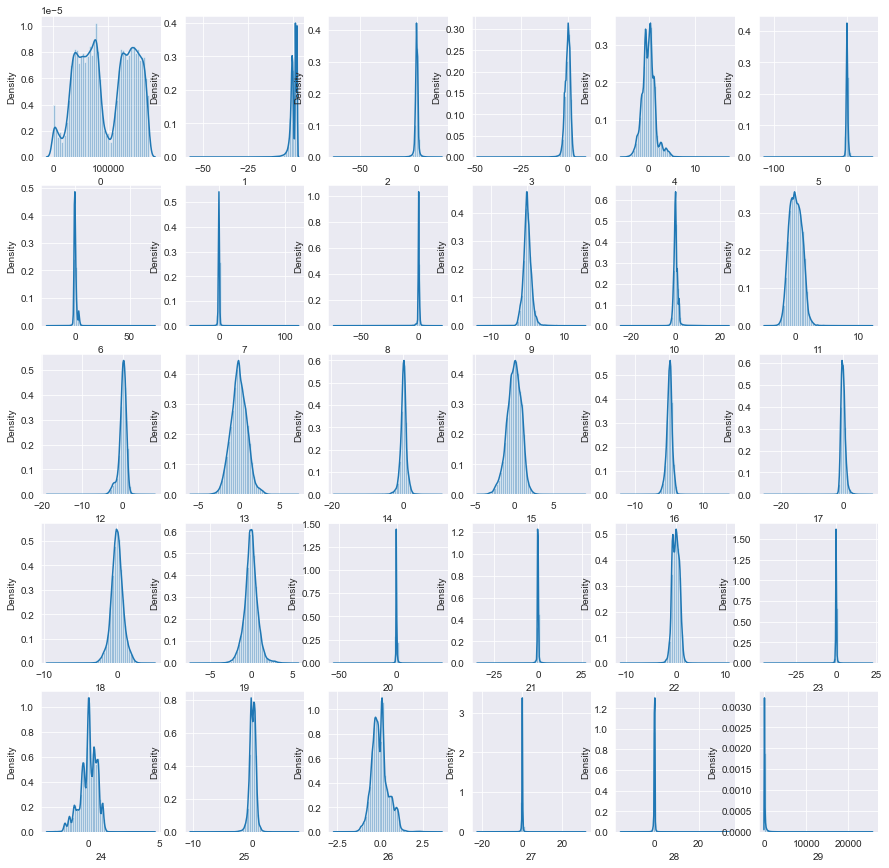

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
n_rows=5
n_cols=6
x = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize= (15,15))
for i, column in enumerate(x.columns):
    sns.distplot(df[column],ax=axes[i//n_cols,i%n_cols])

In [7]:
df.iloc[:, :-1].describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


## Model Test and Baseline Result
* We will evaluate candidate models using repeated stratified k-fold cross-validation. (층화 표집의 k-fold)

* The k-fold cross-validation procedure provides a good general estimate of model performance that is not too optimistically biased, at least compared to a single train-test split. We will use k=10, meaning each fold will contain about 284807/10 or 28,480 examples.

* Stratified means that each fold will contain the same mixture of examples by class, that is about 99.8 percent to 0.2 percent normal and fraudulent transaction respectively. Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model. We will use 3 repeats. (즉, 층화표집의교차검증을 3번씩 반복하겠다는 의미)

* This means a single model will be fit and evaluated 10 * 3 or 30 times and the mean and standard deviation of these runs will be reported.(시간 문제 상 5-fold로 줄임)
* This can be achieved using the RepeatedStratifiedKFold scikit-learn class.

* We will use the recommended metric of area under precision-recall curve or PR AUC.

* This requires that a given algorithm first predict a probability or probability-like measure. The predicted probabilities are then evaluated using precision and recall at a range of different thresholds for mapping probability to class labels, and the area under the curve of these thresholds is reported as the performance of the model. (모든 구간의 분류 임계값에 걸쳐 precision, recall을 평가하게 됨)

* This metric focuses on the positive class, which is desirable for such a severe class imbalance. It also allows the operator of a final model to choose a threshold for mapping probabilities to class labels (fraud or non-fraud transactions) that best balances the precision and recall of the final model. (fraud에 해당하는 클래스에 대해 집중하게 되기 때문에 imblanced된 데이터에 적합한 평가가 될 수 있음)

In [8]:
def load_dataset():
    # load the dataset as a numpy array
    # retrieve numpy array
    data = dataframe.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    return X, y

In [9]:
# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
    # calculate precision-recall curve
    p, r, _ = precision_recall_curve(y_true, probas_pred)
    # calculate area under curve
    return auc(r, p)

In [10]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [11]:
X,y = load_dataset()
# dummyclassifier 로 평가
# define the reference model
model = DummyClassifier(strategy='constant', constant=1)
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean PR AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean PR AUC: 0.501 (0.000)


## Evaluate Machine Learning Algorithms
* Let’s start by evaluating a mixture of machine learning models on the dataset.

* It can be a good idea to spot check a suite of different nonlinear algorithms on a dataset to quickly flush out what works well and deserves further attention and what doesn’t. (서로 다른 non linear 알고리즘을 먼저 빠르게 학습시켜서 어떤 알고리즘들이 쓰면 좋을지 먼저 판단해보는것도 좋은 방법이다)

* We will evaluate the following machine learning models on the credit card fraud dataset: (Tree model 기반의 algorithm들을 서로 비교해서 적절한 알고리즘 선택 후 parameter 최적화를 진행해 최종 모델을 학습하도록 한다)

    * Bagged Decision Trees (BAG)
    * Random Forest (RF)
    * Extra Trees (ET)

* We will use mostly default model hyperparameters, with the exception of the number of trees in the ensemble algorithms, which we will set to a reasonable default of 100.
* We will define each model in turn and add them to a list so that we can evaluate them sequentially. The get_models() function below defines the list of models for evaluation, as well as a list of model short names for plotting the results later.

In [12]:
def get_models():
    models, names = list(), list()
    # Bagging
    models.append(BaggingClassifier(n_estimators=100))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=100))
    names.append('RF')
    # ET
    models.append(ExtraTreesClassifier(n_estimators=100))
    names.append('ET')
    return models, names

In [13]:
# define models
import time
models, names = get_models()
results = list()

# evaluate each model
for i in range(len(models)):
    initial_time = time.time()
    # evaluate the model and store results
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
    print('{} sec spent for cross validation'.format(time.time()-initial_time))

>BAG 0.841 (0.030)
3915.8295090198517 sec spent for cross validation
>RF 0.854 (0.032)
557.1478035449982 sec spent for cross validation
>ET 0.860 (0.031)
159.3748905658722 sec spent for cross validation


In [16]:
import pickle
with open('models.pkl','wb') as f1:
    pickle.dump(models,f1)

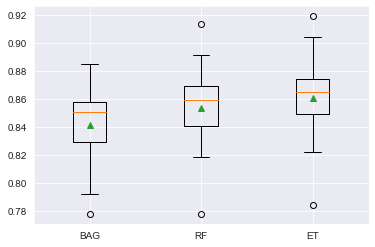

In [17]:
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Make Prediction on New Data

In [19]:
models[2].fit(X,y) #ExtraTreeClassifier
print('Normal cases:')
data = [[0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62],
[0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.183361270123994,-0.145783041325259,-0.0690831352230203,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69],
[1,-1.35835406159823,-1.34016307473609,1.77320934263119,0.379779593034328,-0.503198133318193,1.80049938079263,0.791460956450422,0.247675786588991,-1.51465432260583,0.207642865216696,0.624501459424895,0.066083685268831,0.717292731410831,-0.165945922763554,2.34586494901581,-2.89008319444231,1.10996937869599,-0.121359313195888,-2.26185709530414,0.524979725224404,0.247998153469754,0.771679401917229,0.909412262347719,-0.689280956490685,-0.327641833735251,-0.139096571514147,-0.0553527940384261,-0.0597518405929204,378.66]]
for row in data:
    # make prediction
    yhat = models[2].predict_proba([row])
    # get the probability for the positive class
    result = yhat[0][1]
    # summarize
    print('>Predicted=%.3f (expected 0)' % (result))
# evaluate on some fraud cases (known class 1)
print('Fraud cases:')
data = [[406,-2.3122265423263,1.95199201064158,-1.60985073229769,3.9979055875468,-0.522187864667764,-1.42654531920595,-2.53738730624579,1.39165724829804,-2.77008927719433,-2.77227214465915,3.20203320709635,-2.89990738849473,-0.595221881324605,-4.28925378244217,0.389724120274487,-1.14074717980657,-2.83005567450437,-0.0168224681808257,0.416955705037907,0.126910559061474,0.517232370861764,-0.0350493686052974,-0.465211076182388,0.320198198514526,0.0445191674731724,0.177839798284401,0.261145002567677,-0.143275874698919,0],
[7519,1.23423504613468,3.0197404207034,-4.30459688479665,4.73279513041887,3.62420083055386,-1.35774566315358,1.71344498787235,-0.496358487073991,-1.28285782036322,-2.44746925511151,2.10134386504854,-4.6096283906446,1.46437762476188,-6.07933719308005,-0.339237372732577,2.58185095378146,6.73938438478335,3.04249317830411,-2.72185312222835,0.00906083639534526,-0.37906830709218,-0.704181032215427,-0.656804756348389,-1.63265295692929,1.48890144838237,0.566797273468934,-0.0100162234965625,0.146792734916988,1],
[7526,0.00843036489558254,4.13783683497998,-6.24069657194744,6.6757321631344,0.768307024571449,-3.35305954788994,-1.63173467271809,0.15461244822474,-2.79589246446281,-6.18789062970647,5.66439470857116,-9.85448482287037,-0.306166658250084,-10.6911962118171,-0.638498192673322,-2.04197379107768,-1.12905587703585,0.116452521226364,-1.93466573889727,0.488378221134715,0.36451420978479,-0.608057133838703,-0.539527941820093,0.128939982991813,1.48848121006868,0.50796267782385,0.735821636119662,0.513573740679437,1]]
for row in data:
    # make prediction
    yhat = models[2].predict_proba([row])
    # get the probability for the positive class
    result = yhat[0][1]
    # summarize
    print('>Predicted=%.3f (expected 1)' % (result))

Normal cases:
>Predicted=0.000 (expected 0)
>Predicted=0.000 (expected 0)
>Predicted=0.000 (expected 0)
Fraud cases:
>Predicted=1.000 (expected 1)
>Predicted=1.000 (expected 1)
>Predicted=1.000 (expected 1)


## Wrap-up
* fraud detection과 같은 문제는 전형적인 imbalanced data 에 기반한 모델링이 되어야 한다.
* 본 예제에서는 여러 모델들을 평가하는 방법을 제시함. 특히 imbalanced data 의 분류 문제에서 precision-recall curve를 metric으로 설정하고 repeated-stratified-cross-validation을 활용해 모델들을 평가할 수 있음
* metric 산출 - cross-validation - model 정의 - running 으로 code 구성